In [4]:
!pip install transformers accelerate bitsandbytes torch datasets scikit-learn matplotlib seaborn umap-learn huggingface_hub -q

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline as hf_pipeline
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans # For optional K-Means visualization
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login, HfFolder

# --- User Configuration ---
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
use_quantization = True # Highly recommended for Colab

# --- Hugging Face Token ---
print("Attempting Hugging Face login...")
try:
    if HfFolder.get_token() is None:
        print("Hugging Face token not found in cache. Please log in when prompted.")
        login()
        print("Login successful (or token was already cached and valid).")
    else:
        print(f"Hugging Face token found in cache: {HfFolder.get_token()[:10]}... (masked)")
except Exception as e:
    print(f"Error during Hugging Face login attempt: {e}")
    print("Please ensure you have a valid Hugging Face token with access to Llama 3.")
    raise


Attempting Hugging Face login...
Hugging Face token not found in cache. Please log in when prompted.


Login successful (or token was already cached and valid).


In [7]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: Running on CPU will be very slow. Ensure GPU is enabled in Colab Runtime.")

# --- Load Tokenizer and Model ---
print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer for '{MODEL_NAME}' loaded.")

print(f"Loading model '{MODEL_NAME}'...")
if use_quantization:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded with 4-bit quantization.")
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded without quantization.")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        if hasattr(model, 'config') and model.config.pad_token_id is None:
            model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Set pad_token to eos_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))
        if hasattr(model, 'config'):
            model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Added new pad_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

print("Cell 1 Setup Complete. Model and tokenizer should be loaded.")

Using device: cuda
Loading tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct'...


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct' loaded.
Loading model 'meta-llama/Meta-Llama-3-8B-Instruct'...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model 'meta-llama/Meta-Llama-3-8B-Instruct' loaded with 4-bit quantization.
Set pad_token to eos_token: <|eot_id|> (ID: 128009)
Cell 1 Setup Complete. Model and tokenizer should be loaded.


In [8]:
# Cell 2: Define Concept (Sentiment) and Prepare Data for Concept Vector (v_C)
# This cell defines the positive and negative example texts for calculating the sentiment v_C.
# It remains the same as in previous iterations.

CONCEPT_NAME = "sentiment"

# Texts for calculating the concept vector (v_C)
positive_texts_for_vc = [
    "This is a wonderful experience and I am very happy.",
    "I love this product, it's absolutely fantastic!",
    "The weather is beautiful today, perfect for a walk.",
    "She gave a truly inspiring and uplifting speech.",
    "What a delightful surprise, it made my day!"
]

negative_texts_for_vc = [
    "This is a terrible situation and I am very upset.",
    "I hate this product, it's absolutely awful!",
    "The weather is miserable today, dreadful for any activity.",
    "His comments were deeply frustrating and disheartening.",
    "What a horrible incident, it ruined everything."
]

print(f"Concept for v_C: {CONCEPT_NAME}")
print(f"Number of positive examples for v_C definition: {len(positive_texts_for_vc)}")
print(f"Number of negative examples for v_C definition: {len(negative_texts_for_vc)}")

Concept for v_C: sentiment
Number of positive examples for v_C definition: 5
Number of negative examples for v_C definition: 5


Targeting module for v_C ACTIVATION EXTRACTION: MLP of Layer 29 (LlamaMLP)
Registered v_C extraction hook on mlp_layer_minus_3_for_vc.
Using token aggregation strategy: -1 for MLP v_C activation extraction.
MLP Activations for v_C extracted. Pos shape: torch.Size([5, 4096]), Neg shape: torch.Size([5, 4096])

Training Linear Probe on MLP Activations for Iteration 5 Concept Vector...
Linear probe on MLP (L29) activations trained. Accuracy: 100.00%
Concept vector (v_C) from MLP PROBE calculated. Shape: torch.Size([4096])
MLP v_C Activation extraction hook removed.

Running PCA on MLP (L29) activations used for probe...


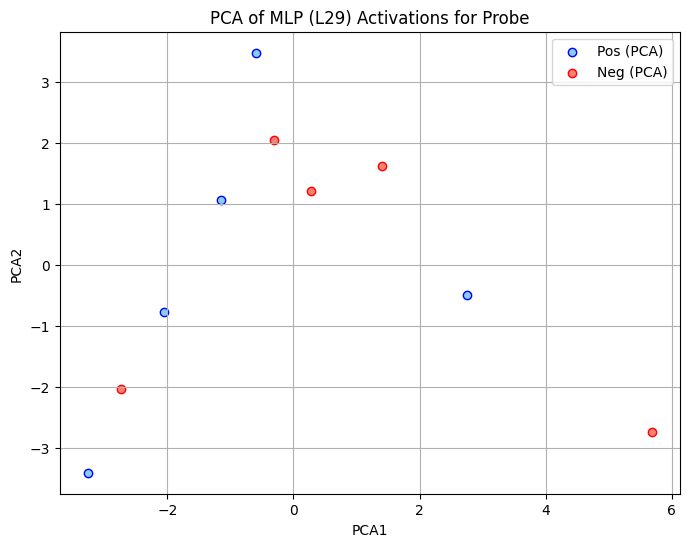

In [9]:
# Cell 3: MODIFIED for Iteration 5 - MLP-Derived Concept Vector ($v_C$)

# --- Helper function to register a hook and store activations ---
activations_storage = {}
def get_activation_hook(layer_name_in_storage):
    def hook(model_module, M_input, M_output):
        # The output of an MLP layer in Llama is typically just the tensor of hidden states.
        # For a full LlamaDecoderLayer, M_output is a tuple (hidden_states, attn_weights, past_kv).
        # We need to be mindful of what `model_module` (the hooked module) returns.
        if isinstance(M_output, tuple): # Likely from a full LlamaDecoderLayer
            activations_storage[layer_name_in_storage] = M_output[0].detach()
        else: # Likely from an MLP sub-module or similar (returns a tensor)
            activations_storage[layer_name_in_storage] = M_output.detach()
    return hook

# --- Determine the target MLP layer for v_C Extraction ---
target_module_for_vc_extraction = None
hook_handle_vc_extraction = None
# Name for storing activations specifically for this MLP-derived v_C
vc_extraction_hook_storage_name = "mlp_layer_minus_3_for_vc"

try:
    num_model_layers_vc = len(model.model.layers)
    # Target the MLP of Layer -3 (index 29 for a 32-layer model)
    vc_extraction_layer_idx_from_end = -3
    vc_extraction_actual_layer_idx = num_model_layers_vc + vc_extraction_layer_idx_from_end

    if not (0 <= vc_extraction_actual_layer_idx < num_model_layers_vc):
        raise ValueError(f"Calculated vc_extraction_actual_layer_idx {vc_extraction_actual_layer_idx} is out of bounds.")

    # Access the MLP sub-module of the chosen decoder layer
    # For Llama models, this is typically `model.model.layers[INDEX].mlp`
    target_module_for_vc_extraction = model.model.layers[vc_extraction_actual_layer_idx].mlp
    print(f"Targeting module for v_C ACTIVATION EXTRACTION: MLP of Layer {vc_extraction_actual_layer_idx} ({type(target_module_for_vc_extraction).__name__})")

except Exception as e:
    print(f"Error accessing MLP layer for v_C extraction: {e}. Please check model structure.")

# --- Register the forward hook for v_C extraction ---
if target_module_for_vc_extraction:
    if 'hook_handle_vc_extraction' in globals() and hook_handle_vc_extraction is not None:
        try: hook_handle_vc_extraction.remove(); print("Removed pre-existing v_C extraction hook.")
        except: pass
    hook_handle_vc_extraction = target_module_for_vc_extraction.register_forward_hook(get_activation_hook(vc_extraction_hook_storage_name))
    print(f"Registered v_C extraction hook on {vc_extraction_hook_storage_name}.")
else:
    print("Skipping v_C extraction hook registration as target MLP module not found.")

# --- Function to get activations (remains largely the same) ---
def get_activations_for_texts_batch(texts_batch, storage_name, agg_token_strategy=-1):
    inputs = tokenizer(texts_batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    if storage_name in activations_storage: del activations_storage[storage_name]
    with torch.no_grad(): _ = model(**inputs) # Forward pass triggers hook on the MLP
    batch_activations = activations_storage.get(storage_name)
    if batch_activations is None: raise ValueError(f"Activations not found: '{storage_name}'. Hook issue on MLP?")
    batch_activations_cpu = batch_activations.cpu()
    if agg_token_strategy == 'mean': return batch_activations_cpu.mean(dim=1)
    elif agg_token_strategy == -1:
        seq_lens = inputs.attention_mask.sum(dim=1)
        return torch.stack([batch_activations_cpu[i, max(0, seq_lens[i].item()-1), :] for i in range(batch_activations_cpu.shape[0])])
    else: return batch_activations_cpu[:, agg_token_strategy, :]

# --- Initialize concept_vector_sentiment_mlp ---
concept_vector_sentiment_mlp = None # Use a new name for this iteration's v_C
positive_activations_for_mlp_vc, negative_activations_for_mlp_vc = None, None

# --- Extract MLP activations and Train Probe ---
if hook_handle_vc_extraction and target_module_for_vc_extraction:
    token_aggregation_strategy = -1 # Using last token's activations from MLP output
    print(f"Using token aggregation strategy: {token_aggregation_strategy} for MLP v_C activation extraction.")
    try:
        positive_activations_for_mlp_vc = get_activations_for_texts_batch(positive_texts_for_vc, vc_extraction_hook_storage_name, token_aggregation_strategy)
        negative_activations_for_mlp_vc = get_activations_for_texts_batch(negative_texts_for_vc, vc_extraction_hook_storage_name, token_aggregation_strategy)
        print(f"MLP Activations for v_C extracted. Pos shape: {positive_activations_for_mlp_vc.shape}, Neg shape: {negative_activations_for_mlp_vc.shape}")

        print("\nTraining Linear Probe on MLP Activations for Iteration 5 Concept Vector...")
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import StandardScaler
        all_acts_for_mlp_probe_torch = torch.cat([positive_activations_for_mlp_vc, negative_activations_for_mlp_vc], dim=0)
        all_acts_for_mlp_probe_numpy = all_acts_for_mlp_probe_torch.to(torch.float32).numpy()
        mlp_probe_labels = np.array([1]*len(positive_activations_for_mlp_vc) + [0]*len(negative_activations_for_mlp_vc))

        mlp_scaler = StandardScaler(); all_mlp_acts_scaled = mlp_scaler.fit_transform(all_acts_for_mlp_probe_numpy)

        mlp_probe_classifier = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', random_state=42)
        mlp_probe_classifier.fit(all_mlp_acts_scaled, mlp_probe_labels)
        accuracy = mlp_probe_classifier.score(all_mlp_acts_scaled, mlp_probe_labels)
        print(f"Linear probe on MLP (L{vc_extraction_actual_layer_idx}) activations trained. Accuracy: {accuracy*100:.2f}%")

        mlp_probe_weights = mlp_probe_classifier.coef_[0]
        concept_vector_sentiment_mlp = torch.tensor(mlp_probe_weights, dtype=torch.bfloat16).to(device)
        # Optional: concept_vector_sentiment_mlp = concept_vector_sentiment_mlp / torch.norm(concept_vector_sentiment_mlp)
        print(f"Concept vector (v_C) from MLP PROBE calculated. Shape: {concept_vector_sentiment_mlp.shape}")
    except Exception as e:
        print(f"Error during MLP v_C activation extraction or probe training: {e}")
        concept_vector_sentiment_mlp = None
    finally:
        if hook_handle_vc_extraction: hook_handle_vc_extraction.remove(); print("MLP v_C Activation extraction hook removed.")

    # --- Optional Visualizations of MLP Activations used for Probe Training ---
    if positive_activations_for_mlp_vc is not None and negative_activations_for_mlp_vc is not None:
        all_mlp_extracted_activations_float32 = torch.cat([positive_activations_for_mlp_vc, negative_activations_for_mlp_vc], dim=0).to(torch.float32)
        all_mlp_extracted_activations_numpy = all_mlp_extracted_activations_float32.numpy()
        n_positive_mlp = len(positive_texts_for_vc)
        print(f"\nRunning PCA on MLP (L{vc_extraction_actual_layer_idx}) activations used for probe...");
        pca_mlp = PCA(n_components=2); projected_pca_mlp = pca_mlp.fit_transform(all_mlp_extracted_activations_numpy);
        plt.figure(figsize=(8,6));
        plt.scatter(projected_pca_mlp[:n_positive_mlp,0], projected_pca_mlp[:n_positive_mlp,1],label="Pos (PCA)",c="skyblue",edgecolors='b');
        plt.scatter(projected_pca_mlp[n_positive_mlp:,0], projected_pca_mlp[n_positive_mlp:,1],label="Neg (PCA)",c="salmon",edgecolors='r');
        plt.xlabel("PCA1");plt.ylabel("PCA2"); plt.title(f"PCA of MLP (L{vc_extraction_actual_layer_idx}) Activations for Probe"); plt.legend(); plt.grid(True); plt.show()
        # Add t-SNE, UMAP, etc., here if desired for MLP activations
else:
    print("Initial hook setup for MLP v_C extraction failed. Concept vector cannot be calculated.")

In [10]:
# Cell 3.5: Estimate Activation Ranges for Clipping at Target STEERING Layer
# This cell remains the same as in Iteration 4. It estimates clipping ranges
# based on the output of the FULL DECODER BLOCK of Layer -3 (index 29),
# as this is where we intend to APPLY our steering intervention.

min_val_clip = -10.0
max_val_clip = 10.0
target_module_for_stats = None
hook_handle_stats = None

try:
    num_model_layers_stats = len(model.model.layers)
    # Layer -3 (index 29 for 32-layer model) was our champion steering layer
    layer_for_stats_idx_from_end = -3
    layer_for_stats_actual_idx = num_model_layers_stats + layer_for_stats_idx_from_end

    if not (0 <= layer_for_stats_actual_idx < num_model_layers_stats):
        raise ValueError(f"Calculated layer_for_stats_actual_idx {layer_for_stats_actual_idx} is out of bounds.")

    # IMPORTANT: Stats are from the *output of the full decoder layer* where steering is applied
    target_module_for_stats = model.model.layers[layer_for_stats_actual_idx]
    stats_hook_storage_name = f"layer_{layer_for_stats_actual_idx}_full_block_stats_activations"
    print(f"Targeting module for activation stats (for clipping ranges): FULL Decoder Layer {layer_for_stats_actual_idx} ({type(target_module_for_stats).__name__})")
except Exception as e:
    print(f"Error setting up target_module_for_stats: {e}")

if target_module_for_stats:
    stats_prompts = [
        "The weather today is expected to be clear and sunny.",
        "Standard operational procedures require daily system checks.",
        "A detailed agenda was distributed before the conference began."
        # Add more diverse, neutral prompts if needed
    ]

    activations_for_stats_list = []

    if 'activations_storage' not in globals(): activations_storage = {}
    else:
        if stats_hook_storage_name in activations_storage: del activations_storage[stats_hook_storage_name]

    if target_module_for_stats:
        if 'hook_handle_stats' in globals() and hook_handle_stats is not None:
            try: hook_handle_stats.remove(); print("Removed pre-existing stats hook.")
            except: pass
        # Use the same get_activation_hook, it correctly gets output[0] for full layers
        hook_handle_stats = target_module_for_stats.register_forward_hook(get_activation_hook(stats_hook_storage_name))
        print(f"Registered temporary hook on FULL Decoder Layer {layer_for_stats_actual_idx} for stats gathering.")

        print(f"Gathering activations from FULL Decoder Layer {layer_for_stats_actual_idx} for clipping range estimation...")
        for text in stats_prompts:
            messages = [{"role": "user", "content": text}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
            inputs = tokenizer(prompt_string, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            if inputs.input_ids.shape[1] == 0: continue
            with torch.no_grad(): _ = model(**inputs)
            current_activations = activations_storage.get(stats_hook_storage_name)
            if current_activations is not None:
                activations_for_stats_list.append(current_activations.cpu().to(torch.float32).view(-1))
            else: print(f"Warning: No activations for '{stats_hook_storage_name}' after prompt: {text[:30]}...")

        if hook_handle_stats: hook_handle_stats.remove(); print("Temporary stats hook removed.")

    if activations_for_stats_list:
        all_stats_activations = torch.cat(activations_for_stats_list)
        if all_stats_activations.numel() > 0 :
            # Using a fixed generous range as per previous successful Iteration 4 test
            min_val_clip = -25.0
            max_val_clip = 25.0
            print(f"Using FIXED WIDER clipping range: [{min_val_clip:.4f}, {max_val_clip:.4f}] (based on Iter. 4 success)")
            # Optionally, you can still print percentile based stats for comparison/information:
            # min_perc_val = torch.quantile(all_stats_activations, 0.01).item()
            # max_perc_val = torch.quantile(all_stats_activations, 0.99).item()
            # print(f"  For reference, 1st Percentile: {min_perc_val:.4f}, 99th Percentile: {max_perc_val:.4f}")
        else: print("No activation values collected for stats. Using default fixed clipping values.")
    else: print("No activations collected for stats. Using default fixed clipping values.")
else:
    print("Target module for stats not set. Using default fixed clipping values.")


Targeting module for activation stats (for clipping ranges): FULL Decoder Layer 29 (LlamaDecoderLayer)
Registered temporary hook on FULL Decoder Layer 29 for stats gathering.
Gathering activations from FULL Decoder Layer 29 for clipping range estimation...
Temporary stats hook removed.
Using FIXED WIDER clipping range: [-25.0000, 25.0000] (based on Iter. 4 success)


In [12]:
# These will be used by Cell 5
final_min_clip_i5 = min_val_clip
final_max_clip_i5 = max_val_clip
print(f"FINAL Clipping range to be used for Iteration 5 steering: [{final_min_clip_i5:.4f}, {final_max_clip_i5:.4f}]")

# Cell 4: Evaluation Setup & Test Prompts
# This cell remains identical to the version used in Iteration 4.
# It defines test_prompts_base, score_concept_control, and calculate_perplexity.

test_prompts_base = ["The report covered several key areas of the project", "During the weekly meeting, the team discussed", "The system update is scheduled to deploy", "Feedback from the initial user testing indicated", "Further analysis of the data revealed that"]
sentiment_classifier_pipe, ppl_model, ppl_tokenizer = None, None, None
try:
    sentiment_classifier_pipe = hf_pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1); print("Sentiment classifier loaded.")
except Exception as e: print(f"Error loading sentiment classifier: {e}")

def score_concept_control(generated_texts, target_sentiment_label="POSITIVE", target_score_threshold=0.7):
    if not generated_texts or sentiment_classifier_pipe is None: return 0.0
    valid_texts = [t for t in generated_texts if isinstance(t, str) and t.strip()];
    if not valid_texts: return 0.0
    sentiments = sentiment_classifier_pipe(valid_texts)
    controlled_count = sum(1 for r in sentiments if r['label'].upper() == target_sentiment_label.upper() and r['score'] > target_score_threshold)
    return (controlled_count / len(valid_texts)) * 100 if valid_texts else 0.0

try:
    ppl_model_name = "gpt2"; print(f"Loading PPL model: {ppl_model_name}...")
    ppl_tokenizer = AutoTokenizer.from_pretrained(ppl_model_name)
    ppl_model = AutoModelForCausalLM.from_pretrained(ppl_model_name).to(device)
    if ppl_tokenizer.pad_token is None: ppl_tokenizer.pad_token = ppl_tokenizer.eos_token
    print(f"PPL model '{ppl_model_name}' loaded.")
except Exception as e: print(f"Error loading PPL model: {e}")

def calculate_perplexity(texts_list):
    if not texts_list or ppl_model is None: return float('inf')
    total_nll, total_tokens, valid_texts_count = 0, 0, 0
    for text_item in texts_list:
        if not isinstance(text_item, str) or not text_item.strip(): continue
        max_len = ppl_tokenizer.model_max_length if ppl_tokenizer.model_max_length < 100000 else 1024
        encodings = ppl_tokenizer(text_item,return_tensors="pt",padding=True,truncation=True,max_length=max_len).to(device)
        if encodings.input_ids.numel() == 0: continue
        valid_texts_count +=1
        with torch.no_grad(): outputs = ppl_model(encodings.input_ids, labels=encodings.input_ids)
        total_nll += outputs.loss.item() * encodings.input_ids.size(1); total_tokens += encodings.input_ids.size(1)
    if total_tokens == 0: return float('inf')
    return torch.exp(torch.tensor(total_nll / total_tokens)).item()
print("Evaluation functions and test_prompts_base defined for Iteration 5.")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


FINAL Clipping range to be used for Iteration 5 steering: [-25.0000, 25.0000]


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Sentiment classifier loaded.
Loading PPL model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PPL model 'gpt2' loaded.
Evaluation functions and test_prompts_base defined for Iteration 5.


In [13]:
# Cell 5: MODIFIED for Iteration 5 - Steering Experiment with MLP-Derived $v_C$

# Check if the MLP-derived concept vector from Cell 3 is available
if 'concept_vector_sentiment_mlp' not in globals() or concept_vector_sentiment_mlp is None:
    print("ERROR: `concept_vector_sentiment_mlp` is not defined from Cell 3. Cannot run Iteration 5.")
elif 'final_min_clip_i5' not in globals() or 'final_max_clip_i5' not in globals():
    print("ERROR: `final_min_clip_i5` or `final_max_clip_i5` not defined from Cell 3.5. Cannot run Iteration 5.")
else:
    print(f"Proceeding with Iteration 5 using MLP-derived $v_C$. Shape: {concept_vector_sentiment_mlp.shape}.")
    print(f"Using Clipping range from Cell 3.5: [{final_min_clip_i5:.4f}, {final_max_clip_i5:.4f}]")

    # --- Iteration 5 Configuration ---
    # We will steer at our champion layer: Layer -3 (index 29)
    champion_actual_layer_index_i5 = -1 # Placeholder
    try:
        num_model_layers_i5 = len(model.model.layers)
        champion_layer_idx_from_end_i5 = -3
        champion_actual_layer_index_i5 = num_model_layers_i5 + champion_layer_idx_from_end_i5

        if not (0 <= champion_actual_layer_index_i5 < num_model_layers_i5):
            raise ValueError(f"Champion steering layer index {champion_actual_layer_index_i5} out of bounds.")
        # This is the module where steering is APPLIED (full decoder block)
        champion_steering_module_i5 = model.model.layers[champion_actual_layer_index_i5]
        champion_steering_module_i5.layer_idx = champion_actual_layer_index_i5
        print(f"Champion STEERING module for Iteration 5: FULL Decoder Layer {champion_actual_layer_index_i5} ({type(champion_steering_module_i5).__name__})")
    except Exception as e:
        print(f"Error setting champion_steering_module for Iteration 5: {e}. Cannot proceed."); champion_steering_module_i5 = None

    # Champion alphas from previous bests
    alpha_positive_champion_i5 = 0.5
    alpha_negative_champion_i5 = -1.0

    max_new_gen_tokens_i5 = 40
    tokenizer_input_max_len_i5 = 512
    iteration_results_i5 = {}

    # --- Steering Hook Function (can reuse from Iteration 4, just ensure it takes clip values) ---
    def steering_hook_fn_i5(concept_vector_to_add, alpha_value,
                            p_clip_min, p_clip_max, steer_token_idx=-1):
        def hook(module, M_input, M_output):
            original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
            modified_output_tensor = original_output_tensor.clone()
            cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)
            if steer_token_idx == -1:
                modified_output_tensor[:, -1:, :] = modified_output_tensor[:, -1:, :] + (alpha_value * cv_on_correct_device.unsqueeze(0))

            modified_output_tensor = torch.clamp(modified_output_tensor, p_clip_min, p_clip_max)

            if isinstance(M_output, tuple): return (modified_output_tensor,) + M_output[1:]
            else: return modified_output_tensor
        return hook

    # --- Generate and Evaluate Function (adapted for Iteration 5 logging) ---
    def generate_and_evaluate_i5(current_run_name, prompts_base_list, steering_module_for_hook,
                                 apply_steering=False, concept_vec=None, # This will be concept_vector_sentiment_mlp
                                 alpha_val=0, target_sentiment_for_ccs=None,
                                 use_clipping=False, p_min_clip_val=-25.0, p_max_clip_val=25.0): # Default to fixed wide
        generated_texts_for_eval = []
        hook_handle_steering_i5 = None

        steering_status_msg = "No steering / Baseline"
        if apply_steering and steering_module_for_hook and concept_vec is not None:
            clip_status = "ON" if use_clipping else "OFF"
            steering_status_msg = f"Steering MLP_vC @ L{getattr(steering_module_for_hook, 'layer_idx', 'N/A')}, Alpha:{alpha_val:.2f}, Clip:{clip_status}"

            if use_clipping: # Only use clipping if specified
                steering_hook_instance = steering_hook_fn_i5(concept_vec, alpha_val, p_min_clip_val, p_max_clip_val, steer_token_idx=-1)
            else: # Create a hook that doesn't clip if use_clipping is False
                def no_clip_steering_hook_fn(concept_vector_to_add, alpha_value, steer_token_idx=-1):
                    def hook(module, M_input, M_output):
                        original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
                        modified_output_tensor = original_output_tensor.clone()
                        cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)
                        if steer_token_idx == -1:
                            modified_output_tensor[:, -1:, :] = modified_output_tensor[:, -1:, :] + (alpha_value * cv_on_correct_device.unsqueeze(0))
                        if isinstance(M_output, tuple): return (modified_output_tensor,) + M_output[1:]
                        else: return modified_output_tensor
                    return hook
                steering_hook_instance = no_clip_steering_hook_fn(concept_vec, alpha_val, steer_token_idx=-1)

            hook_handle_steering_i5 = steering_module_for_hook.register_forward_hook(steering_hook_instance)

        print(f"\nGenerating texts for '{current_run_name}' ({steering_status_msg})...")

        for p_base in prompts_base_list:
            messages = [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": f"{p_base}, and in summary, the general feeling was"}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(prompt_string, return_tensors="pt", max_length=tokenizer_input_max_len_i5, truncation=True).to(device)
            if inputs.input_ids.shape[1] == 0: generated_texts_for_eval.append(""); continue
            try:
                with torch.no_grad():
                    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=max_new_gen_tokens_i5,
                                             temperature=0.7, do_sample=True, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
                full_decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_len = inputs.input_ids.shape[1]; completion_only = tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
                print(f"  Prompt: '{p_base[:50]}...' -> Completion: '{completion_only[:100]}...'")
                generated_texts_for_eval.append(full_decoded_text)
            except Exception as e: print(f"  Error: {e}"); generated_texts_for_eval.append("")
        if hook_handle_steering_i5: hook_handle_steering_i5.remove()

        current_ppl = calculate_perplexity(generated_texts_for_eval)
        current_ccs = 0.0
        if target_sentiment_for_ccs and generated_texts_for_eval:
            current_ccs = score_concept_control(generated_texts_for_eval, target_sentiment_for_ccs)

        iteration_results_i5[current_run_name] = {"ppl": current_ppl, "ccs": current_ccs if target_sentiment_for_ccs else "N/A",
                                                  "outputs": generated_texts_for_eval, "alpha": alpha_val,
                                                  "steering_layer_idx": getattr(steering_module_for_hook, 'layer_idx', 'N/A' if apply_steering else 'Baseline'),
                                                  "clipping": "ON" if (apply_steering and use_clipping) else "OFF",
                                                  "vc_source": "MLP_L-3" if apply_steering else "N/A"}
        print(f"Results for '{current_run_name}': PPL: {current_ppl:.2f}", end="")
        if target_sentiment_for_ccs: print(f", CCS ({target_sentiment_for_ccs}): {current_ccs:.2f}%")
        else: print("")
        return generated_texts_for_eval

    # --- Main Execution for Iteration 5 ---
    if champion_steering_module_i5 and ('concept_vector_sentiment_mlp' in globals() and concept_vector_sentiment_mlp is not None):
        print("\n--- Iteration 5: Evaluating Steering with MLP-Derived $v_C$ ---")
        print(f"Using MLP-Derived $v_C$ (from MLP of Layer {vc_extraction_actual_layer_idx}).")
        print(f"Applying steering at Champion FULL Decoder Layer: {champion_actual_layer_index_i5}")
        print(f"Using Clipping Range: [{final_min_clip_i5:.4f}, {final_max_clip_i5:.4f}] for positive steering.")

        # 1. Positive Steering WITH MLP_vC & Clipping ON
        generate_and_evaluate_i5(
            current_run_name=f"MLP_vC_L{champion_actual_layer_index_i5}_clip_ON_pos_alpha_{alpha_positive_champion_i5:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i5,
            apply_steering=True,
            concept_vec=concept_vector_sentiment_mlp, # Use MLP-derived v_C
            alpha_val=alpha_positive_champion_i5,
            target_sentiment_for_ccs="POSITIVE",
            use_clipping=True,
            p_min_clip_val=final_min_clip_i5,
            p_max_clip_val=final_max_clip_i5
        )

        # 2. Negative Steering WITH MLP_vC & Clipping OFF
        generate_and_evaluate_i5(
            current_run_name=f"MLP_vC_L{champion_actual_layer_index_i5}_clip_OFF_neg_alpha_{alpha_negative_champion_i5:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i5,
            apply_steering=True,
            concept_vec=concept_vector_sentiment_mlp, # Use MLP-derived v_C
            alpha_val=alpha_negative_champion_i5,
            target_sentiment_for_ccs="NEGATIVE",
            use_clipping=False # Clipping OFF for negative, as per best results
        )

        print("\n--- Iteration 5 Evaluation Complete ---")
        print("\nSummary of Iteration 5 Results (MLP-Derived $v_C$):")
        for run_name, metrics in iteration_results_i5.items():
            print(f"  Run: {run_name}, SteeringLayer: {metrics.get('steering_layer_idx', 'N/A')}, Alpha: {metrics.get('alpha', 'N/A'):.1f}, Clip: {metrics.get('clipping', 'N/A')}, PPL: {metrics.get('ppl', 'N/A'):.2f}, CCS: {metrics.get('ccs', 'N/A')}")

        print("\nRecall Best Iteration 4 results (Probe $v_C$ from Full Layer Output, Steering at L29):")
        print("  CHAMPION POSITIVE (Iter 4): (L29, alpha 0.5, Clip ON [-25,25]): CCS 100.0%, PPL 45.15")
        print("  CHAMPION NEGATIVE (Iter 3): (L29, alpha -1.0, Clip OFF): CCS 80.0%, PPL 35.23")
    else:
        print("Skipping Iteration 5 due to missing prerequisites (champion_steering_module, concept_vector_sentiment_mlp, or clip values).")

Proceeding with Iteration 5 using MLP-derived $v_C$. Shape: torch.Size([4096]).
Using Clipping range from Cell 3.5: [-25.0000, 25.0000]
Champion STEERING module for Iteration 5: FULL Decoder Layer 29 (LlamaDecoderLayer)

--- Iteration 5: Evaluating Steering with MLP-Derived $v_C$ ---
Using MLP-Derived $v_C$ (from MLP of Layer 29).
Applying steering at Champion FULL Decoder Layer: 29
Using Clipping Range: [-25.0000, 25.0000] for positive steering.

Generating texts for 'MLP_vC_L29_clip_ON_pos_alpha_0.5' (Steering MLP_vC @ L29, Alpha:0.50, Clip:ON)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'Please go ahead and share the report and the general feeling that was summarized. I'll do my best to...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'What did the team discuss during the weekly meeting, and what was the general feeling that emerged f...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'The

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


  Prompt: 'Further analysis of the data revealed that...' -> Completion: 'It sounds like you've gathered some valuable insights from the data analysis! I'd love to help you s...'
Results for 'MLP_vC_L29_clip_ON_pos_alpha_0.5': PPL: 44.65, CCS (POSITIVE): 80.00%

Generating texts for 'MLP_vC_L29_clip_OFF_neg_alpha_-1.0' (Steering MLP_vC @ L29, Alpha:-1.00, Clip:OFF)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'Please go ahead and share the report's summary. I'll do my best to help you summarize the key points...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'I'm happy to help! However, I need a bit more information from you. Could you please provide more co...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'I'm happy to help! However, I think there might be some confusion. As a helpful assistant, I'm not a...'
  Prompt: 'Feedback from the initial user testing indicated...' -> Completion: 'Ple